In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def f(x):
  return 3*x**2 - 4*x + 5

In [4]:
f(3.0)

20.0

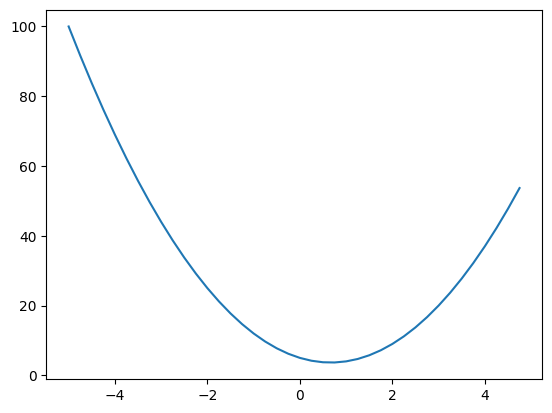

In [5]:
xs = np.arange(-5, 5, 0.25)
# print(xs)
ys = f(xs)
plt.plot(xs, ys)

In [6]:
class Value:

  def __init__(self, data, _children=(), _op = '', label =''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (float, int))
    out = Value(self.data ** other, (self, ), f'**{other}')

    def _backward():
      self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __radd__(self, other):
    return self + other

  def __rsub__(self, other):
    return self - other

  def __rmul__(self, other): # other * self
    return self * other

  def __rtruediv__(self, other):
    return other * (self**-1)

  def __truediv__(self, other): #  self / other = self * (other)**-1
    return self * other**-1

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out =  Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad # where out.data = math.exp(x)
    out._backward = _backward

    return out

  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    # topo
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c= Value(10.0, label='c')

e = a * b; e.label = 'e'
d = e + c ; d.label = 'd'
f = Value(-2.0, label='f')
L= d * f; L.label = 'L'
L

Value(data=-8.0)

In [7]:
a = Value(2.0) ; b = Value(3.0)
# b / a
3+a

Value(data=5.0)

In [8]:
from graphviz import Digraph

def trace(root):
  #builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child,v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  #LR = left to right

  nodes, edges = trace(root)
  # print(f"nodes: {nodes}")
  # print(f"edges: {edges}")
  for n in nodes:
    uid = str(id(n))
    #for any value in the graph, create a rectangular ('record') node for it
    dot.node(name= uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      #if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    #connect n1 to the op node of n2
    #where n1 is child node and n2 is parent node(d, e and L) resulting from an operation.
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot



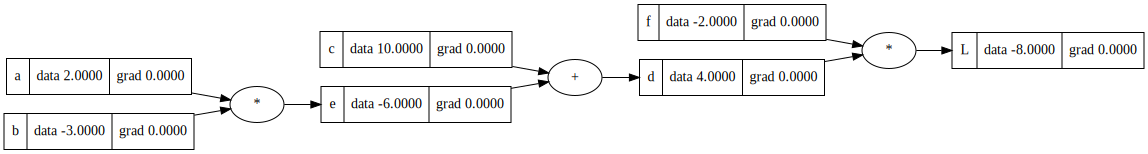

In [9]:
draw_dot(L)

In [10]:
# input x1, x2
x1 = Value(2.0, label= 'x1')
x2 = Value(0.0, label= 'x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label= 'w2')

# bias of the neuron
b = Value(6.8813735870195432, label= 'b')

#x1*w1 + x2*w2 + b

x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b ; n.label = 'n'
o = n.tanh(); o.label = 'o' #activation function for n

o.backward()

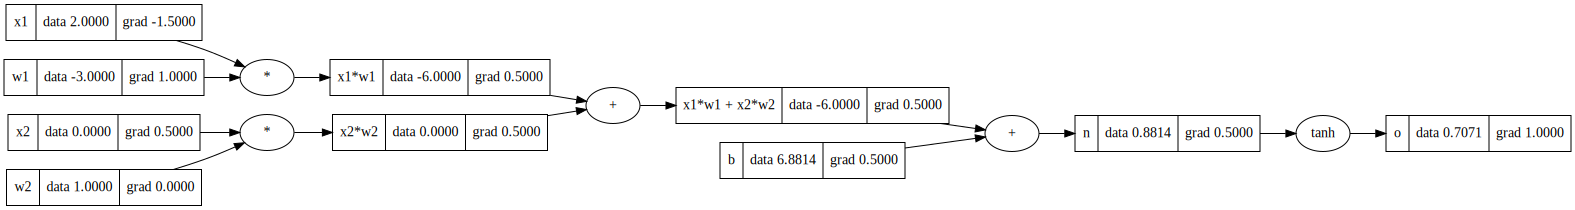

In [11]:
draw_dot(o)

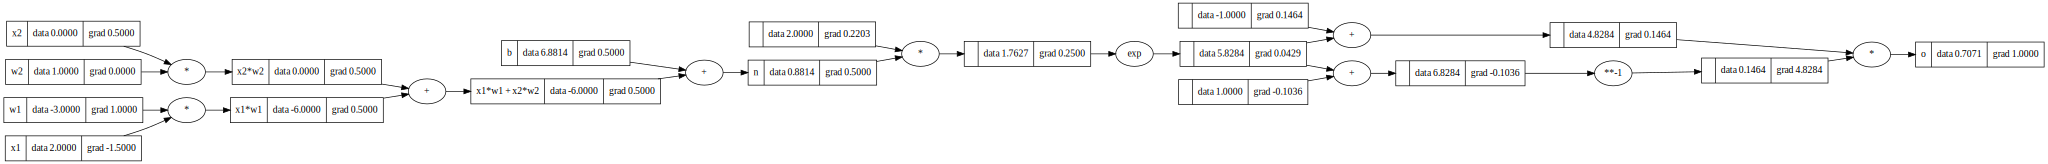

In [12]:
# input x1, x2
x1 = Value(2.0, label= 'x1')
x2 = Value(0.0, label= 'x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label= 'w2')

# bias of the neuron
b = Value(6.8813735870195432, label= 'b')

#x1*w1 + x2*w2 + b

x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b ; n.label = 'n'

# ----------
e = (2*n).exp()
o = (e - 1)/(e + 1); o.label = 'o' #activation function for n
# ----------
o.backward()

draw_dot(o)

In [17]:
import torch
import random

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [398]:
class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
     act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
     out = act.tanh()
     return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    print(sz)
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]



In [399]:
x = [2.0, 3.0, -1.0] # nin and x should have the same size because of the zip method.
n = MLP(3, [4,4,1])
n(x)
# len(n.parameters())

[3, 4, 4, 1]


Value(data=0.4958914583761666)

In [400]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [458]:

for k in range(40):

  #forward pass
  ypred = [n(x) for x in xs]
  loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])

  #Backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update / gradient descent
  for p in n.parameters():
    p.data += -0.8 * p.grad

  print(k, loss.data)


0 5.638295672187132e-05
1 5.6282815198094684e-05
2 5.618302024172267e-05
3 5.608357007323418e-05
4 5.598446292522187e-05
5 5.5885697042268914e-05
6 5.5787270680857434e-05
7 5.568918210927746e-05
8 5.5591429607505274e-05
9 5.549401146712176e-05
10 5.5396925991218385e-05
11 5.53001714942823e-05
12 5.520374630212118e-05
13 5.510764875175051e-05
14 5.5011877191316904e-05
15 5.491642997999576e-05
16 5.482130548789808e-05
17 5.472650209598983e-05
18 5.463201819599067e-05
19 5.453785219029271e-05
20 5.444400249186515e-05
21 5.4350467524178456e-05
22 5.4257245721107096e-05
23 5.4164335526849094e-05
24 5.407173539584057e-05
25 5.397944379266999e-05
26 5.38874591920043e-05
27 5.379578007848749e-05
28 5.37044049466816e-05
29 5.3613332300969324e-05
30 5.3522560655485376e-05
31 5.343208853402982e-05
32 5.3341914469991826e-05
33 5.325203700627683e-05
34 5.316245469522039e-05
35 5.30731660985268e-05
36 5.298416978717156e-05
37 5.289546434135379e-05
38 5.280704835039767e-05
39 5.271892041269793e-05


In [459]:
ypred

[Value(data=0.9963380135763322),
 Value(data=-0.9969467605046503),
 Value(data=-0.9957439206237642),
 Value(data=0.996554380640177)]

In [397]:
#forward pass
ypred = [n(x) for x in xs]
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=8.464052539661859e-21)

In [395]:
#Backward pass
loss.backward()

In [396]:
# update / gradient descent
for p in n.parameters():
  p.data += -0.05 * p.grad

In [387]:
n.layers[0].neurons[0].w[0].grad

-0.727036336402379

In [386]:
n.layers[0].neurons[0].w[0].data

1.130398120540921

In [375]:
n.parameters()

[Value(data=-0.4960712964926773),
 Value(data=0.290350350881446),
 Value(data=-0.16106749317190028),
 Value(data=0.9437170910360031),
 Value(data=0.4794656253902896),
 Value(data=-0.0598411792446351),
 Value(data=0.5812826572956342),
 Value(data=0.6953495524407052),
 Value(data=-0.9109132246637858),
 Value(data=-0.24395923756696308),
 Value(data=0.39214513649163923),
 Value(data=0.1707159689495833),
 Value(data=-0.1664382723782107),
 Value(data=-0.6731358730873958),
 Value(data=1.3657875815750076),
 Value(data=0.25511170470243244),
 Value(data=0.11619689363073053),
 Value(data=0.22321107161203427),
 Value(data=-0.6153565931009739),
 Value(data=-0.3092578166660296),
 Value(data=0.7336479437214618),
 Value(data=-0.9351704842356952),
 Value(data=1.0306525480172004),
 Value(data=0.9616083256463601),
 Value(data=1.3785210646226735),
 Value(data=0.04646165514250647),
 Value(data=0.08673343757387378),
 Value(data=0.6965423724175767),
 Value(data=-0.6007301876427028),
 Value(data=0.67099999823

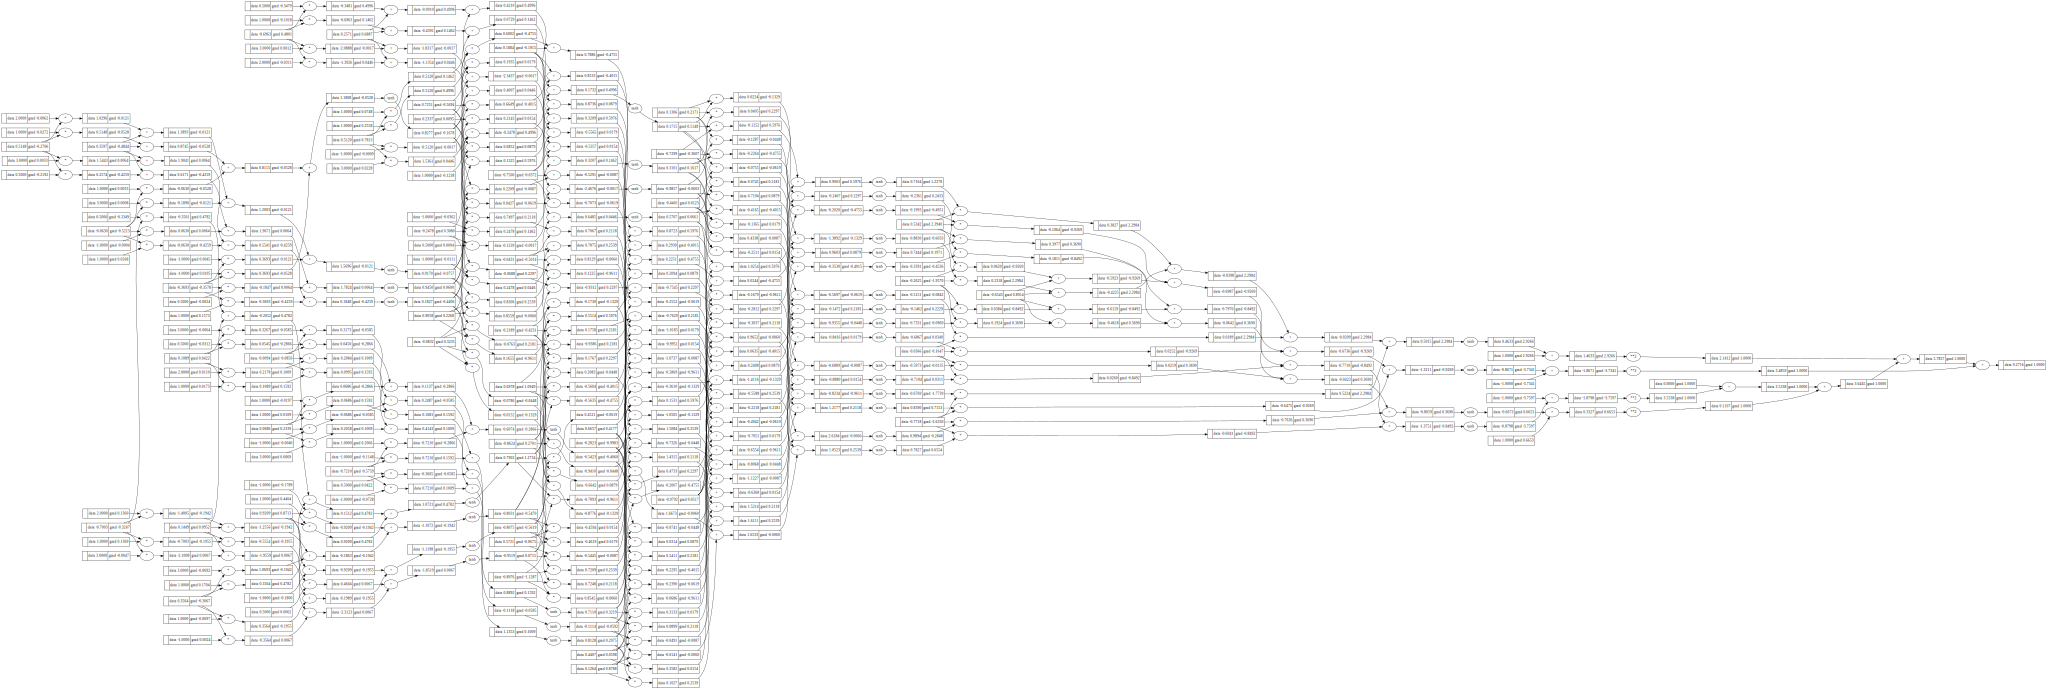

In [179]:
draw_dot(loss)

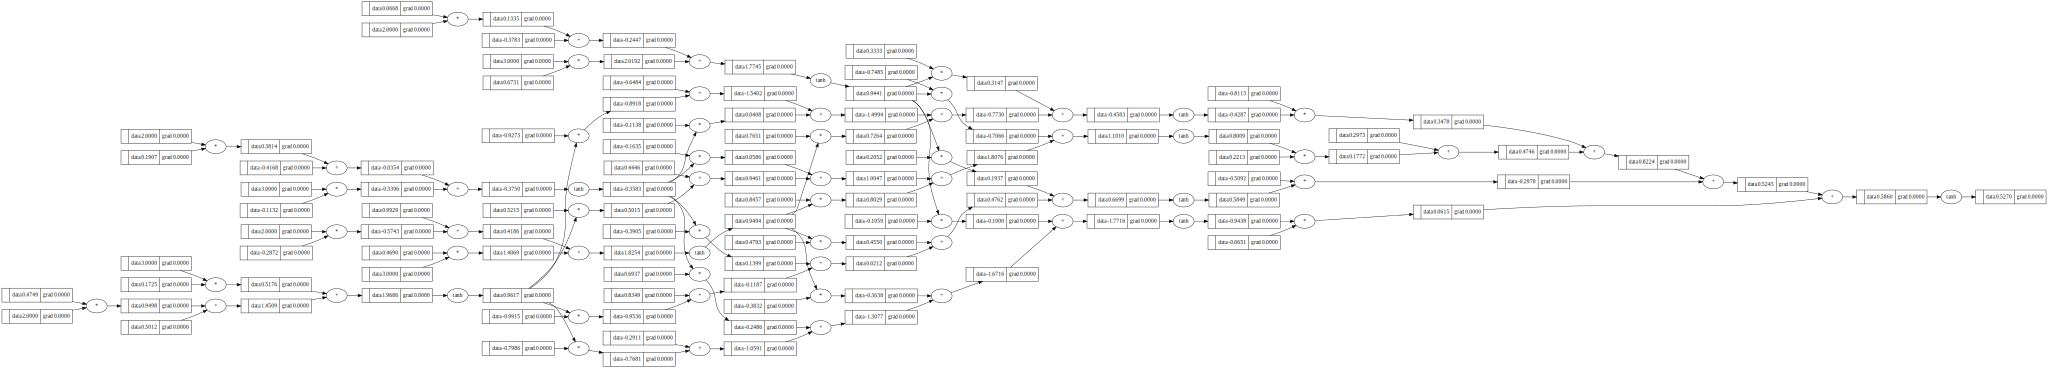

In [82]:
draw_dot(n(x))

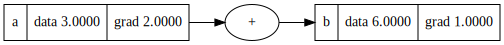

In [160]:
a = Value(3.0, label='a'); c = Value(6.0, label= 'c')
b = a + a  ; b.label = 'b'
# b.grad = 1.0
# b._backward()
b.backward()
draw_dot(b)

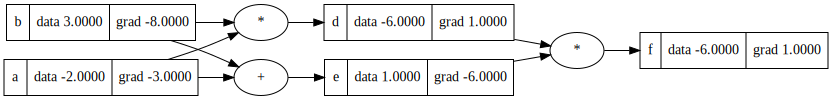

In [81]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

In [ ]:
o.grad = 1.0

o._backward()
n._backward()
x1w1x2w2._backward()
b._backward()
x1w1._backward()
x2w2._backward()

In [ ]:
o.grad = 1.0 # do/do
n.grad = 1-o.data**2 # where n.grad = do/dn = tanh(n)**2. Similarly, o.data = tanh(n.data)
b.grad = n.grad # do/db = do/dn * dn/db
x1w1x2w2.grad = n.grad # do/dx1w1x2w2 = do/dn * dn/dx1w1x2w2
x1w1.grad = x1w1x2w2.grad # do/x1w1 = do/dx1w1x2w2 * dx1w1x2w2/x1w1
x2w2.grad = x1w1x2w2.grad # do/x2w2 = do/dx1w1x2w2 * dx1w1x2w2/x2w2
x1.grad = x1w1.grad * w1.data # do/dx1 = do/dx1w1 * dx1w1/dx1
w1.grad = x1w1.grad * x1.data # do/dw1 = do/dx1w1 * dx1w1/dw1
x2.grad = x2w2.grad * w2.data # do/dx2 = do/dx2w2 * dx2w2/dx2
w2.grad = x2w2.grad * x2.data # do/dx2 = do/dx2w2 * dx2w2/dx2

In [ ]:
L.grad = 1.0
f.grad = d.data
d.grad = f.data
c.grad = -2.0
e.grad = -2.0
a.grad = -2.0*-3.0
b.grad = -2.0*2.0

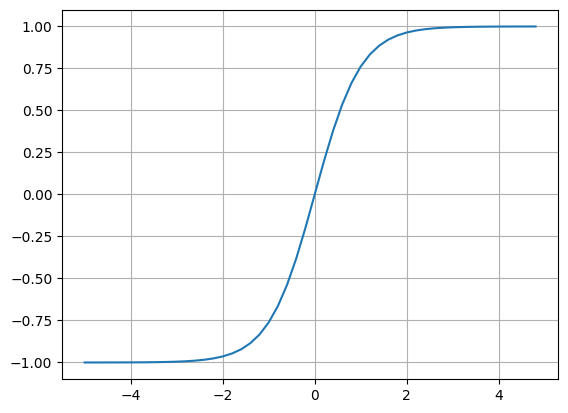

In [ ]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid()

In [ ]:
def derivative():

  h = 0.0001
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c= Value(10.0, label='c')

  e = a * b; e.label = 'e'
  d = e + c ; d.label = 'd'
  f = Value(-2.0, label='f')
  L= d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0+h, label='b')
  c= Value(10.0, label='c')
  e = a * b; e.label = 'e'
  d = e + c ; d.label = 'd'
  f = Value(-2.0, label='f')
  L= d * f; L.label = 'L'
  L2 = L.data

  print((L2-L1)/h)

derivative()

-4.000000000008441


In [ ]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-7.286496


In [ ]:
a.label
type(d._prev)
# g= Value(3.0,([4,5]), '/','g')
g = set([1,2,3,4])
g.add((3))
print(g)
for i in g:
  uid = str(id(i))
  print(f"uid: {uid}")

{1, 2, 3, 4}
uid: 136394273014000
uid: 136394273014032
uid: 136394273014064
uid: 136394273014096
